In [1]:
# please install pyproj ($ conda install -c https://conda.anaconda.org/jjhelmus pyproj) 
#and install mplleaflet ($ pip install mplleaflet)

%pylab inline
import numpy as np
import pylab as pl
import sklearn.cluster
from sklearn import mixture
from PIL import Image
from scipy.misc import imread
from scipy.cluster.vq import kmeans2
import json
import os
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)
import pandas as pd
import csv
import pylab as pl
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
import geopandas as gpd
import scipy.cluster as scp
from scipy.cluster.vq import whiten
from geopy.distance import great_circle
import mplleaflet
import scipy.spatial.distance as sd
import urllib2

kelly_colors_hex = [
    '#FFB300', # Vivid Yellow
    '#803E75', # Strong Purple
    '#FF6800', # Vivid Orange
    '#A6BDD7', # Very Light Blue
    '#C10020', # Vivid Red
    '#CEA262', # Grayish Yellow
    '#817066', # Medium Gray
    '#007D34', # Vivid Green
    '#F6768E', # Strong Purplish Pink
    '#00538A', # Strong Blue
    '#FF7A5C', # Strong Yellowish Pink
    '#53377A', # Strong Violet
    '#FF8E00', # Vivid Orange Yellow
    '#B32851', # Strong Purplish Red
    '#F4C800', # Vivid Greenish Yellow
    '#7F180D', # Strong Reddish Brown
    '#93AA00', # Vivid Yellowish Green
    '#593315', # Deep Yellowish Brown
    '#F13A13', # Vivid Reddish Orange
    '#232C16', # Dark Olive Green
    ]

Populating the interactive namespace from numpy and matplotlib


/Users/JianhaoZhou/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/JianhaoZhou/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
#import Graffiti Cleaning Spot Data
df = pd.read_csv('20151014_Cleaning_DownloadSites.csv', sep=';')
#print df

In [4]:
# convert 'xcoord' and 'ycoord' into "lat" and "lon" and create new columns in df
import pyproj as pp
lon, lat  = [], []
df['lon'] = np.zeros(len(df['Service Request#']))
df['lat'] = np.zeros(len(df['Service Request#']))

coord = df.as_matrix(columns = df.columns[13:15])
for i in coord:
    proj = pp.Proj(init='epsg:2263', preserve_units=True)
    x, y = i[0], i[1]
    lon1,lat1 = proj(x, y, inverse=True)
    lon.append(lon1)
    lat.append(lat1)

df['lat'] = np.array(lat)
df['lon'] = np.array(lon)


# create coordinates array with lat and lon
coordinates = df.as_matrix(columns=['lon', 'lat'])
D = len(coordinates[0])
N = len(coordinates)
print "number of features: ", D
print "number of data points: ", N
# print coordinates

number of features:  2
number of data points:  336


In [5]:
#import NYPD Motor Vehicle Collisions data
url = "https://db.tt/eRhRzCLi" 
df2 = pd.read_csv(urllib2.urlopen(url))
#print df2

In [6]:
#calculate total level of injuries (NUMBER OF PERSONS INJURED + 3*NUMBER OF PERSONS KILLED), the standard of which is arguable
#and create factors in df by zip code based on this
print df2.columns
total = (df2['NUMBER OF PERSONS INJURED'].groupby(df2['ZIP CODE']).sum()) + 3*(df2['NUMBER OF PERSONS KILLED'].groupby(df2['ZIP CODE']).sum())
print 
mean = np.mean(total)
std = np.std(total)

for i in range(len(total)):
    total.iloc[i] = 1+((total.iloc[i]-mean)/5/std)

print np.min(total),np.max(total)

df['Factor']=[total[i] for i in df['Zip']]


Index([u'﻿DATE', u'TIME', u'BOROUGH', u'ZIP CODE', u'LATITUDE', u'LONGITUDE',
       u'LOCATION', u'ON STREET NAME', u'CROSS STREET NAME',
       u'OFF STREET NAME', u'NUMBER OF PERSONS INJURED',
       u'NUMBER OF PERSONS KILLED', u'NUMBER OF PEDESTRIANS INJURED',
       u'NUMBER OF PEDESTRIANS KILLED', u'NUMBER OF CYCLIST INJURED',
       u'NUMBER OF CYCLIST KILLED', u'NUMBER OF MOTORIST INJURED',
       u'NUMBER OF MOTORIST KILLED', u'CONTRIBUTING FACTOR VEHICLE 1',
       u'CONTRIBUTING FACTOR VEHICLE 2', u'CONTRIBUTING FACTOR VEHICLE 3',
       u'CONTRIBUTING FACTOR VEHICLE 4', u'CONTRIBUTING FACTOR VEHICLE 5',
       u'UNIQUE KEY', u'VEHICLE TYPE CODE 1', u'VEHICLE TYPE CODE 2',
       u'VEHICLE TYPE CODE 3', u'VEHICLE TYPE CODE 4', u'VEHICLE TYPE CODE 5'],
      dtype='object')

0.740255766822 2.08951856017


In [7]:
#zipweight is an NxN matrix that contains the combined effect of the origin and destination zips for point n and m
zipweight = np.zeros( (len(df['Service Request#']),len(df['Service Request#'])) )
print df['Factor'][0]
for i in range(len(df['Service Request#'])):
    for a in range(len(df['Service Request#'])):
        zipweight[i][a]=df['Factor'][i]*df['Factor'][a]

# define linear affinity function for later callable clustering parameter 
def linear_affinity(data):
    d = sd.squareform(sd.pdist(data))
    return d*zipweight


1.02237112892


In [42]:
#plot all Graffiti Cleaning Spots
pl.figure(figsize=(18, 10))
pl.scatter(coordinates[:,0], coordinates[:,1], c='b', alpha=.8, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("All Graffiti Cleaning Spots", fontsize=18)
pl.ylim([40.55,40.92])
pl.xlim([-74.1,-73.7])
mplleaflet.display(tiles=('https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiemhvdWpoNDIiLCJhIjoiY2VkNGU4OGE1YjEwODMxODUyMmUzNjYwZjQyOWNkODMifQ.55ZHYWs5RP3CfpIyrmOisQ',''))


#Kmeans Clustering

In [11]:
# whiten the coordinates
w = whiten(coordinates)
print coordinates.mean(axis=0), w.mean(axis=0)
print coordinates.std(axis=0), w.std(axis=0)


[-73.94377055  40.73761455] [-1237.68909762   498.24589801]
[ 0.05974341  0.08176207] [ 1.  1.]


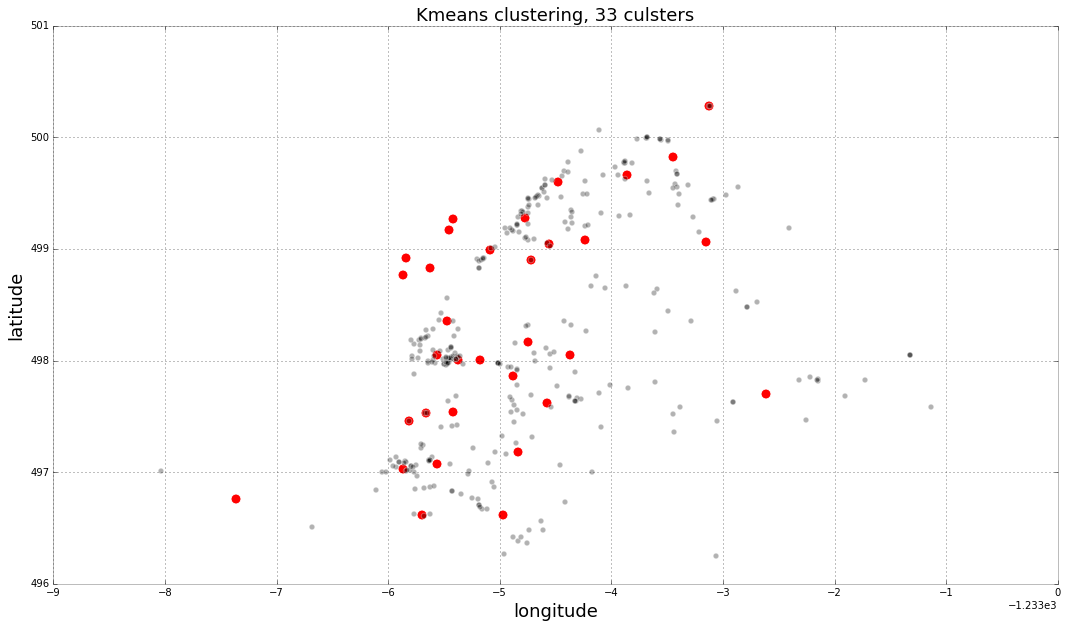

In [34]:
# plot kmeans clustering
num_clusters = len(df['Service Request#'])/10
for i in range(1):
    cluster_centroids, closest_centroids = kmeans2(w, num_clusters, iter=1)
    pl.figure(figsize=(18, 10))
    pl.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c='r', s=100)
    pl.scatter(w[:,0], w[:,1], c='k', alpha=.3, s=30)
    pl.xlabel("longitude", fontsize=18)
    pl.ylabel("latitude", fontsize=18)
    pl.title("Kmeans clustering, %d culsters"%num_clusters, fontsize=18)

In [13]:
#a function to get N different colors from a colormap given an array size N
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

#get the cluster centers
cluster_centroids, closest_centroids = kmeans2(w, num_clusters, iter=1, minit='points')
colors = get_colors(closest_centroids, pl.cm.jet)
colorsc = get_colors(np.arange(num_clusters), pl.cm.jet)

[4, 3, 30, 2, 27, 8, 12, 27, 2, 43, 2, 8, 1, 10, 18, 2, 17, 6, 2, 25, 8, 9, 4, 14, 0, 8, 18, 4, 2, 3, 6, 6, 5]


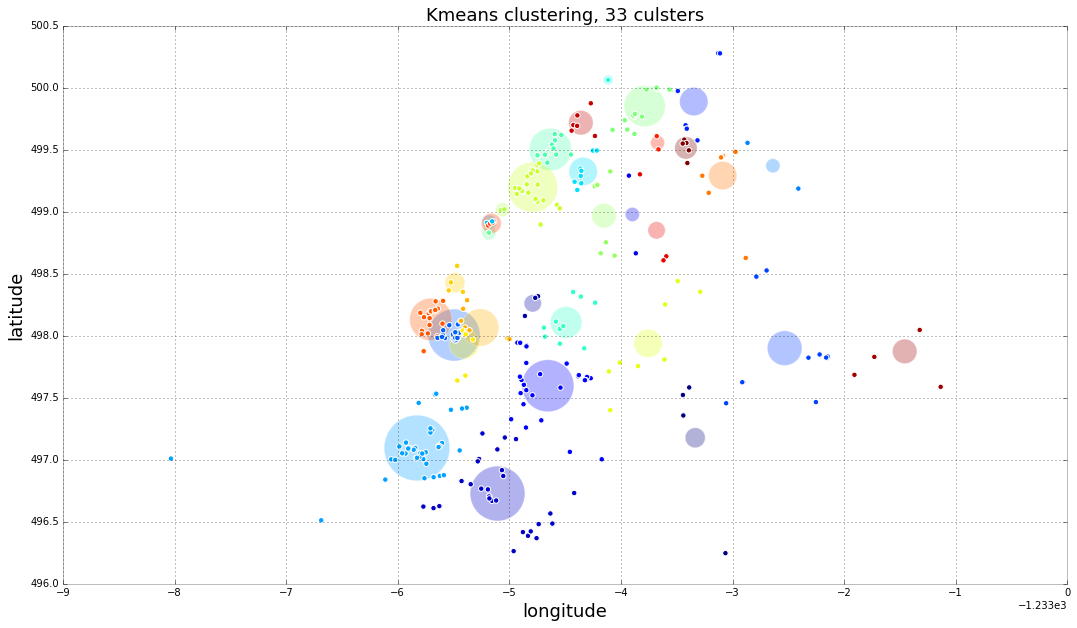

In [33]:
#plot kmeans clustering with different colors for different clusters
plt.figure(figsize=(18, 10), dpi=100)
print [sum(closest_centroids == i) for i in range(num_clusters)]
plt.scatter(cluster_centroids[:,0], cluster_centroids[:,1], c=colorsc, alpha=.3, 
            s=np.array([sum(closest_centroids == i) for i in range(num_clusters)])*100)

pl.scatter(w[:,0], w[:,1], c=colors, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Kmeans clustering, %d culsters"%num_clusters, fontsize=18)
# pl.ylim([40.55,40.92])
# pl.xlim([-74.1,-73.7])

# mplleaflet.show(tiles=('https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiemhvdWpoNDIiLCJhIjoiY2VkNGU4OGE1YjEwODMxODUyMmUzNjYwZjQyOWNkODMifQ.55ZHYWs5RP3CfpIyrmOisQ',''))
# mplleaflet.display(tiles=('https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiemhvdWpoNDIiLCJhIjoiY2VkNGU4OGE1YjEwODMxODUyMmUzNjYwZjQyOWNkODMifQ.55ZHYWs5RP3CfpIyrmOisQ',''))


##Agglomerative Clustering

In [16]:
#function to get the centroid from DBscan as mean of cluster members
def getCentroid(points):
    #print points[:,0], np.nanmean(points[:,0])
    return np.nanmean(points[:,0]), np.nanmean(points[:,1])

In [17]:
#a function to get N different colors from a colormap given an array size N
def get_colors(inp, colormap, vmin=None, vmax=None):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

33


(-74.1, -73.7)

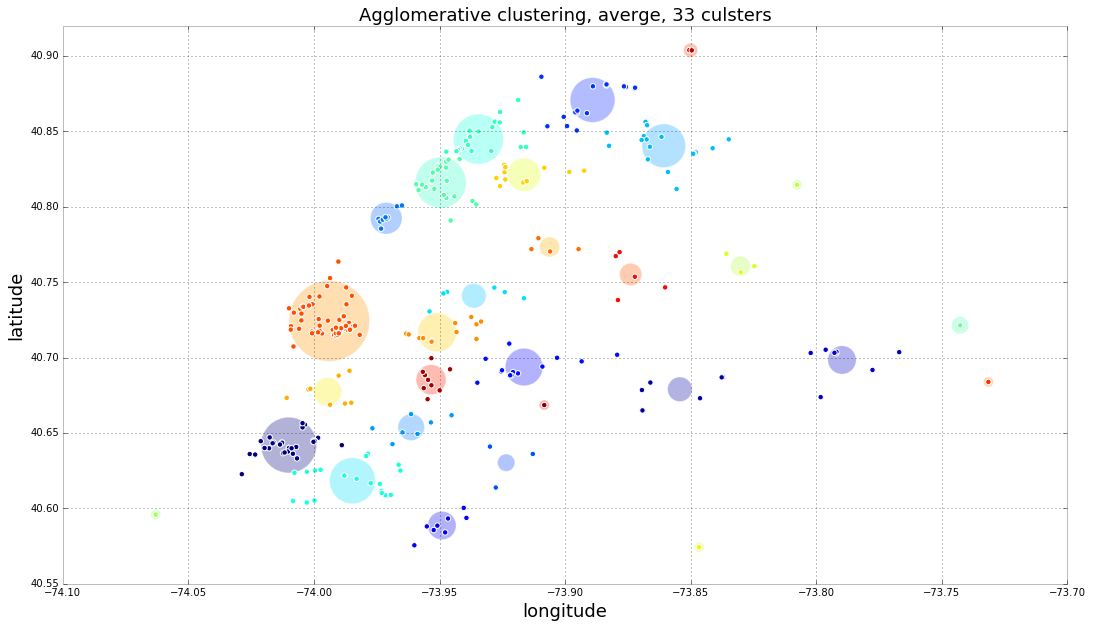

In [31]:
#plot Agglomerative Clustering using manhattan distance
import matplotlib.pyplot as plt

agc = AgglomerativeClustering(n_clusters=30,  
                              linkage='average', 
                              affinity='manhattan').fit(coordinates)
# agc = AgglomerativeClustering(n_clusters = num_clusters, linkage='average', affinity=linear_affinity).fit(coord)
num_clusters = len(df['Service Request#'])/10
labelsag = agc.labels_
centroidsag = np.zeros((num_clusters,2))
print num_clusters

colorsc3 = get_colors(np.arange(num_clusters), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])

pl.figure(figsize=(18, 10), dpi=100)
#print [sum(labelsag == i) for i in range(30)]
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(num_clusters)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, averge, %s culsters" %(str(num_clusters)), fontsize=18) 
pl.ylim([40.55,40.92])
pl.xlim([-74.1,-73.7])


33


(-74.1, -73.7)

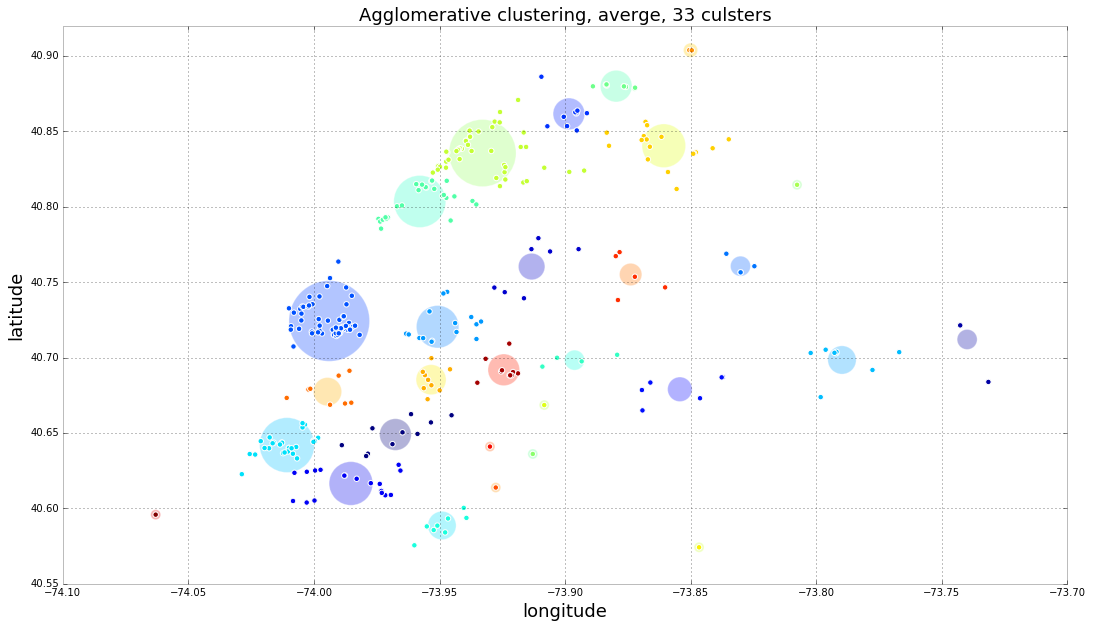

In [32]:
#plot Agglomerative Clustering using weighted distance
agc = AgglomerativeClustering(n_clusters=30,  
                              linkage='average', 
                              affinity=linear_affinity).fit(coordinates)
num_clusters = len(df['Service Request#'])/10
labelsag = agc.labels_
centroidsag = np.zeros((num_clusters,2))
print num_clusters

colorsc3 = get_colors(np.arange(num_clusters), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])

pl.figure(figsize=(18, 10), dpi=100)
#print [sum(labelsag == i) for i in range(30)]
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(num_clusters)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, averge, %s culsters" %(str(num_clusters)), fontsize=18) 
pl.ylim([40.55,40.92])
pl.xlim([-74.1,-73.7])

In [44]:
#plot Agglomerative Clustering using weighted distance in basemap
import mplleaflet
import matplotlib.pyplot as plt

agc = AgglomerativeClustering(n_clusters=30,  
                              linkage='average', 
                              affinity=linear_affinity).fit(coordinates)
num_clusters = len(df['Service Request#'])/10
labelsag = agc.labels_
centroidsag = np.zeros((num_clusters,2))
print num_clusters

colorsc3 = get_colors(np.arange(num_clusters), pl.cm.jet)
colors3 = get_colors(labelsag, pl.cm.jet)
for i in labelsag:
    centroidsag[i] = getCentroid(coordinates[labelsag == i])

pl.figure(figsize=(18, 18), dpi=100)
#print [sum(labelsag == i) for i in range(30)]
pl.scatter(centroidsag[:,0], centroidsag[:,1], c=colorsc3, alpha=.3, 
            s=np.array([sum(labelsag == i) for i in range(num_clusters)])*100)
 
pl.scatter(coordinates[:,0], coordinates[:,1], c=colors3, s=30)
pl.xlabel("longitude", fontsize=18)
pl.ylabel("latitude", fontsize=18)
pl.title("Agglomerative clustering, averge, %s culsters" %(str(num_clusters)), fontsize=18)
pl.ylim([40.55,40.92])
pl.xlim([-74.1,-73.7])

# mplleaflet.show(tiles=('https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiemhvdWpoNDIiLCJhIjoiY2VkNGU4OGE1YjEwODMxODUyMmUzNjYwZjQyOWNkODMifQ.55ZHYWs5RP3CfpIyrmOisQ',''))
# mplleaflet.display(tiles=('https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiemhvdWpoNDIiLCJhIjoiY2VkNGU4OGE1YjEwODMxODUyMmUzNjYwZjQyOWNkODMifQ.55ZHYWs5RP3CfpIyrmOisQ',''))

mplleaflet.display(tiles=('https://api.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiemhvdWpoNDIiLCJhIjoiY2VkNGU4OGE1YjEwODMxODUyMmUzNjYwZjQyOWNkODMifQ.55ZHYWs5RP3CfpIyrmOisQ',''))



33


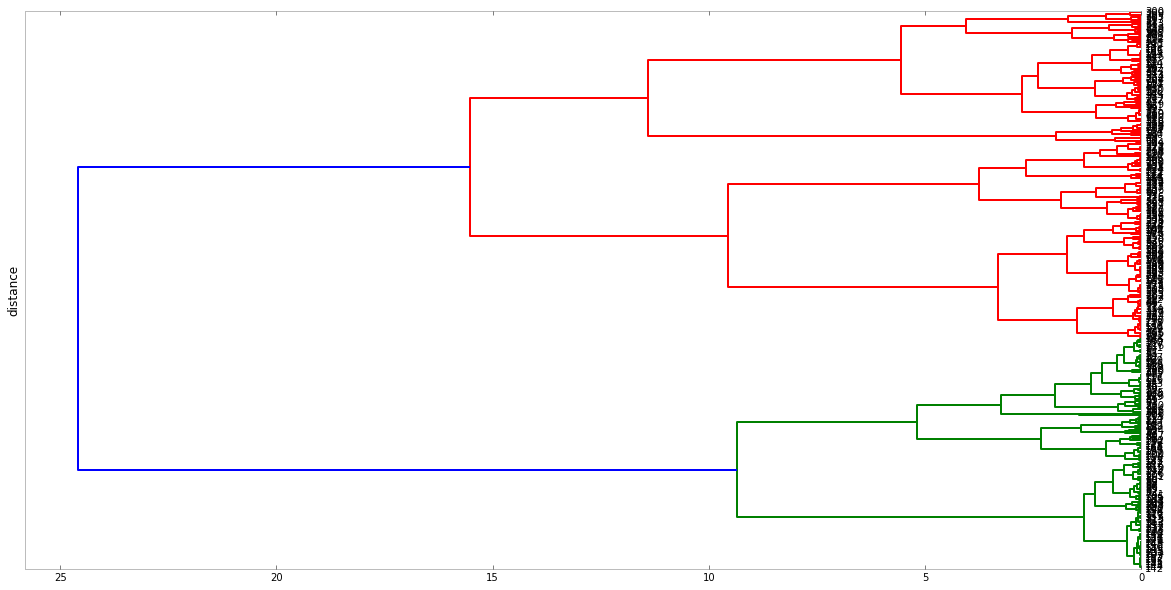

In [36]:
#plot Agglomerative Clustering dendrogram
fig = pl.figure(figsize=(20,10))
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(w, method='ward'),
                               leaf_rotation=90,  # rotates the x axis labels
                               leaf_font_size=8,orientation='right')  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.grid('off')

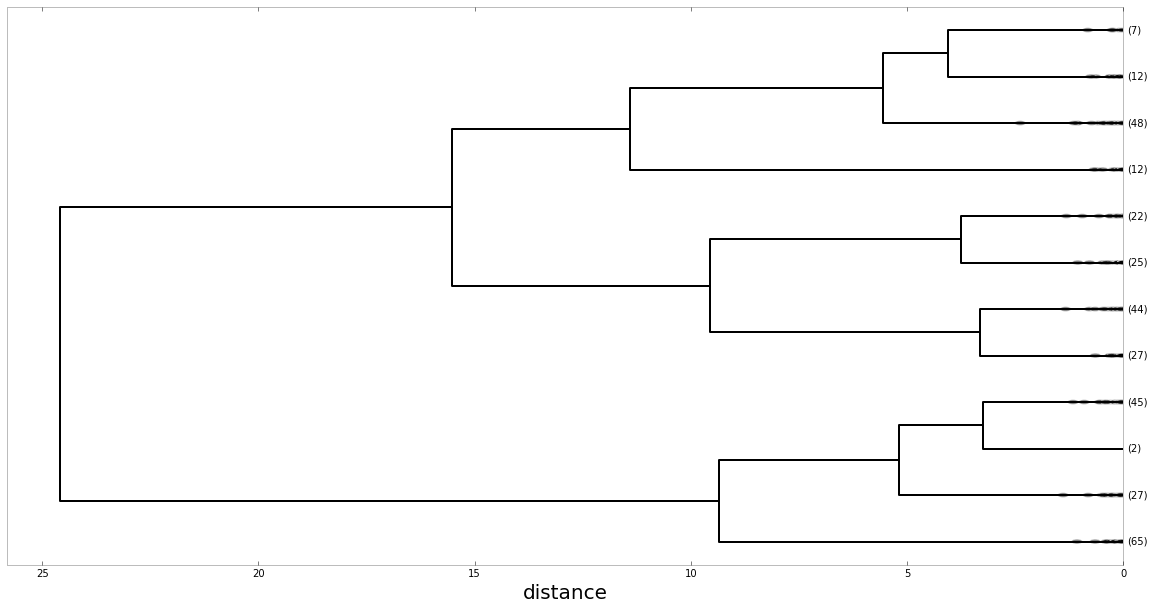

In [37]:
#plot Agglomerative Clustering dendrogram

fig = pl.figure(figsize=(20,10))
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(w, method='ward'),
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=20, truncate_mode='lastp', p=12, 
                               show_contracted=True, color_threshold = 2, 
                               orientation='right', above_threshold_color='k'
                              )  # font size for the x axis labels)
#pl.xticks(rotation=90)
pl.xlabel("distance", fontsize=20)
pl.grid('off')
#scp.hierarchy.dendrogram?

In [46]:
# add the name of the cluster to the dataframe for each site
df['cluster'] = agc.labels_

# print df['Service Request#'].groupby(df['Boro']).count()

# save dataframe to csv
df.to_csv('dsny_site_groups.csv')